# Homework 1

AUTHOR: adamiaonr@gmail.com<br>
DATE: May 21st 2022<br>


In [1]:
# ensure required python modules are installed (discard output)
!pip install --quiet -r '../../../requirements.txt'


In [2]:
# imports & definitions
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from pathlib import Path

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# data directory
DATA_DIR = '../../../data/'

# do not use scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# hide warnings
warnings.filterwarnings('ignore')


## Q1 : Downloading the data

In [3]:
# load parquet data
trip_data = pd.DataFrame()
for path in Path(DATA_DIR).rglob('*.parquet'):
    _trip_data = pd.read_parquet(path)
    # add a ['month'] column to help distinguish the dataset the record came from
    _trip_data['month'] = list(path.parts)[-1].split('_')[-1]
    trip_data = pd.concat([trip_data, _trip_data])

display(trip_data)


,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,month
0,B00013,2021-02-01 00:01:00,2021-02-01 01:33:00,NaN,NaN,None,B00014,2021-02.parquet
1,B00021,2021-02-01 00:55:40,2021-02-01 01:06:20,173.00000,82.00000,None,B00021,2021-02.parquet
2,B00021,2021-02-01 00:14:03,2021-02-01 00:28:37,173.00000,56.00000,None,B00021,2021-02.parquet
3,B00021,2021-02-01 00:27:48,2021-02-01 00:35:45,82.00000,129.00000,None,B00021,2021-02.parquet
4,B00037,2021-02-01 00:12:50,2021-02-01 00:26:38,NaN,225.00000,None,B00037,2021-02.parquet
...,...,...,...,...,...,...,...,...
1154107,B03266,2021-01-31 23:43:03,2021-01-31 23:51:48,7.00000,7.00000,None,B03266,2021-01.parquet
1154108,B03284,2021-01-31 23:50:27,2021-02-01 00:48:03,44.00000,91.00000,None,,2021-01.parquet
1154109,B03285,2021-01-31 23:13:46,2021-01-31 23:29:58,171.00000,171.00000,None,B03285,2021-01.parquet
1154110,B03285,2021-01-31 23:58:03,2021-02-01 00:17:29,15.00000,15.00000,None,B03285,2021-01.parquet


In [4]:
display('Q1: how many data records per month?')
display(trip_data.groupby(['month']).size().reset_index(drop = False, name = 'count'))


'Q1: how many data records per month?'

,month,count
0,2021-01.parquet,1154112
1,2021-02.parquet,1037692


## Q2 : Computing duration

In [5]:
display('Q2: average trip duration (in minutes) per month?')

# add column with trip duration (in minutes)
trip_data['duration'] = ((trip_data['dropOff_datetime'] - trip_data['pickup_datetime']) / pd.Timedelta('1m')).astype(float)
display(trip_data.groupby(['month'])['duration'].mean().reset_index(drop = False))


'Q2: average trip duration (in minutes) per month?'

,month,duration
0,2021-01.parquet,19.16722
1,2021-02.parquet,20.70699


In [6]:
# check distribution of the duration variable
display("initial distribution of ['duration'] (Jan and Feb 2021)")
display(trip_data['duration'].describe())

# filter data : keep durations in interval [1.0, 60.0]
mask = ((trip_data['duration'] >= 1) & (trip_data['duration'] <= 60))
trip_data_filtered = trip_data[mask].reset_index(drop = True)

# how many records were dropped?
display('how many records were dropped (Jan and Feb 2021)?')
display(len(trip_data) - len(trip_data_filtered))


"initial distribution of ['duration'] (Jan and Feb 2021)"

count   2191804.00000
mean         19.89621
std         309.82000
min           0.01667
25%           7.90000
50%          13.76667
75%          23.00000
max      423371.05000
Name: duration, dtype: float64

'how many records were dropped (Jan and Feb 2021)?'

91865

## Q3 : Missing values

In [7]:
# replace missing ['PUlocationID', 'DOlocationID'] w/ '-1'
trip_data_filtered.fillna(value = {'PUlocationID' : -1, 'DOlocationID' : -1}, inplace = True)

display('Q3: fraction of missing values for the PUlocationID (Jan 2021 only)')

# let's use Alexey Grigorev neat trick around 12:25 of https://www.youtube.com/watch?v=iRunifGSHFc
trip_data_filtered_january = trip_data_filtered[trip_data_filtered['month'].str.contains('2021-01')].reset_index(drop = True)
display((trip_data_filtered_january['PUlocationID'] == -1).mean())


'Q3: fraction of missing values for the PUlocationID (Jan 2021 only)'

0.8352732770722617

## Q4 : One-hot encoding

In [8]:
# categorical features : location IDs
categorical = ['PUlocationID', 'DOlocationID']

# need to pass them to str so that to make them ready for dict vectorizer
trip_data_filtered[categorical] = trip_data_filtered[categorical].astype(int).astype(str)


In [9]:
# transform data frame columns into dictionaries (Jan 2021 only)
train_dicts = trip_data_filtered[trip_data_filtered['month'].str.contains('2021-01')][categorical].to_dict(orient = 'records')

# fit a dictionary vectorizer
vectorizer = DictVectorizer()
X_train = vectorizer.fit_transform(train_dicts)


In [10]:
display('Q4 : dimensions of feature matrix (Jan 2021 only)')
X_train.shape


'Q4 : dimensions of feature matrix (Jan 2021 only)'

(1109826, 525)

## Q5 : Training a model

In [11]:
# target variable (Jan 2021 only)
target = 'duration'
y_train = trip_data_filtered[trip_data_filtered['month'].str.contains('2021-01')][target].values


In [12]:
# train simple linear regression model (Jan 2021 only)
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)


LinearRegression()

In [13]:
# apply model to train dataset 
y_predict = linear_regression.predict(X_train)


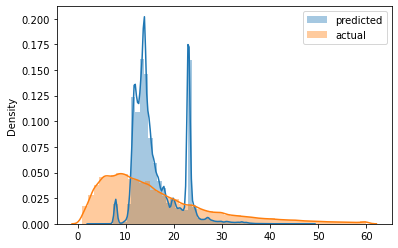

In [14]:
# plot distributions of 'actual' and 'predicted' values
sns.distplot(y_predict, label = 'predicted')
sns.distplot(y_train, label = 'actual')

plt.legend()


In [15]:
display('Q5 : RMSE on training data')
display(mean_squared_error(y_train, y_predict, squared = False))


'Q5 : RMSE on training data'

10.52851938944385

## Q6 : Evaluating the model


In [16]:
# validation data (Feb 2021)
val_dicts = trip_data_filtered[trip_data_filtered['month'].str.contains('2021-02')][categorical].to_dict(orient = 'records')

# dictionary vectorizer (note: only 'transform()' used here, not 'fit_transform()')
X_val = vectorizer.transform(val_dicts)

display('shape of validation feature matrix')
display(X_val.shape)


'shape of validation feature matrix'

(990113, 525)

In [17]:
# actual duration data for Feb 2021
y_val = trip_data_filtered[trip_data_filtered['month'].str.contains('2021-02')][target].values

# run eval data (Feb 2021) through model trained with Jan 2021 data
y_val_predict = linear_regression.predict(X_val)


In [18]:
display('Q6 : RMSE on validation data (Feb 2021)')
display(mean_squared_error(y_val, y_val_predict, squared = False))


'Q6 : RMSE on validation data (Feb 2021)'

11.014286426107942